# ChatBot using Transfer Learning

## Imports

In [1]:
!pip install transformers

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_class_weight
from transformers import AdamW # optimizer from hugging face transformers

import matplotlib.pyplot as plt
import transformers
from transformers import AutoModel, BertTokenizerFast

from preprocess_data import raw_to_json, unzip_entities, tags_patterns_mix, remove_fallback

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [4]:
if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))
device = torch.device("cuda")

device name Tesla K80


## Settings

## Data Preparation

In [5]:
df_train = pd.read_csv('data/Training - Training.csv')
df_test = pd.read_csv('data/Training - Test.csv')

In [6]:
# prepare training data
parent_tags = ['navigate', 'find', 'action']
intents = raw_to_json(df_train)
data = unzip_entities(intents, parent_tags)
df_train = tags_patterns_mix(remove_fallback(data))

In [7]:
# prepare test data
df_test = df_test.drop(df_test[df_test['Tag'] == 'fallback'].index)
df_test.reset_index(inplace=True, drop=True)

In [8]:
df_train.head()

,tag,pattern
0,greeting,Hi
1,greeting,Hey
2,greeting,Hello
3,greeting,Good morning
4,greeting,Good evening


In [9]:
df_test.head()

,Sentence,Tag,Tag_parent
0,Where can I unfollow another person?,find_follow,find
1,How to get to the homepage?,find_homepage,find
2,Where do I find my profile?,find_profile,find
3,Where can I view my feed?,find_personal_feed,find
4,Where can I access the public feed?,find_public_feed,find


In [10]:
df_train.shape, df_test.shape

((1137, 2), (30, 3))

In [11]:
lbl_enc = preprocessing.LabelEncoder()
lbl_enc.fit(df_train['tag'])

LabelEncoder()

In [12]:
df_train['label'] = lbl_enc.transform(df_train['tag'])
df_test['label'] = lbl_enc.transform(df_test['Tag'])

In [13]:
df_train['label'].value_counts(normalize = True)

8     0.087951
14    0.070361
13    0.070361
22    0.061566
11    0.061566
12    0.061566
9     0.061566
10    0.061566
17    0.052770
25    0.049252
6     0.047493
23    0.043096
24    0.043096
28    0.036939
16    0.035180
15    0.035180
26    0.024626
27    0.024626
5     0.015831
19    0.008795
29    0.007036
0     0.007036
18    0.006157
21    0.006157
1     0.006157
20    0.004398
2     0.003518
4     0.002639
3     0.002639
7     0.000880
Name: label, dtype: float64

In [14]:
X_train = df_train['pattern'].to_numpy()
y_train = df_train['label'].to_numpy()
X_test = df_test['Sentence'].to_numpy()
y_test = df_test['label'].to_numpy()

## Import BERT Model & Tokenizer

In [15]:
bert = AutoModel.from_pretrained('bert-base-uncased') # load pretrained BERT model
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased') # load BERT tokenizer

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


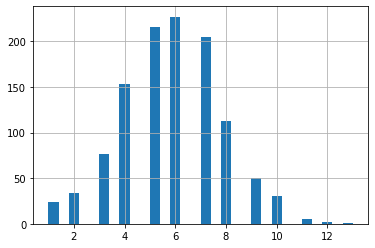

In [17]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in X_train]
pd.Series(seq_len).hist(bins = 30)

In [18]:
max_seq_len = 15

In [19]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length = max_seq_len,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    X_test.tolist(),
    max_length = max_seq_len,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

In [20]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test.tolist())

In [21]:
#define a batch size
batch_size = 1

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [22]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

## Model Architecture

In [23]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      self.dropout = nn.Dropout(0.1) # dropout layer
      self.relu = nn.ReLU() # relu activation function
      self.fc1 = nn.Linear(768,512) # dense layer 1
      self.fc2 = nn.Linear(512,len(np.unique(y_train))) # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1) #softmax activation function

    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x) # output layer
      x = self.softmax(x) # apply softmax activation
      return x

In [24]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [25]:
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [26]:
#compute the class weights
class_wts = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

print(class_wts)

[ 4.7375      5.41428571  9.475      12.63333333 12.63333333  2.10555556
  0.70185185 37.9         0.379       0.54142857  0.54142857  0.54142857
  0.54142857  0.47375     0.47375     0.9475      0.9475      0.63166667
  5.41428571  3.79        7.58        5.41428571  0.54142857  0.77346939
  0.77346939  0.67678571  1.35357143  1.35357143  0.90238095  4.7375    ]


In [27]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 100

## Finetuning

In [28]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [29]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [30]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 100
  Batch    50  of  1,137.
  Batch   100  of  1,137.
  Batch   150  of  1,137.
  Batch   200  of  1,137.
  Batch   250  of  1,137.
  Batch   300  of  1,137.
  Batch   350  of  1,137.
  Batch   400  of  1,137.
  Batch   450  of  1,137.
  Batch   500  of  1,137.
  Batch   550  of  1,137.
  Batch   600  of  1,137.
  Batch   650  of  1,137.
  Batch   700  of  1,137.
  Batch   750  of  1,137.
  Batch   800  of  1,137.
  Batch   850  of  1,137.
  Batch   900  of  1,137.
  Batch   950  of  1,137.
  Batch 1,000  of  1,137.
  Batch 1,050  of  1,137.
  Batch 1,100  of  1,137.

Evaluating...

Training Loss: 3.169
Validation Loss: 4.103

 Epoch 2 / 100
  Batch    50  of  1,137.
  Batch   100  of  1,137.
  Batch   150  of  1,137.
  Batch   200  of  1,137.
  Batch   250  of  1,137.
  Batch   300  of  1,137.
  Batch   350  of  1,137.
  Batch   400  of  1,137.
  Batch   450  of  1,137.
  Batch   500  of  1,137.
  Batch   550  of  1,137.
  Batch   600  of  1,137.
  Batch   650  of  1,137

## Evaluation

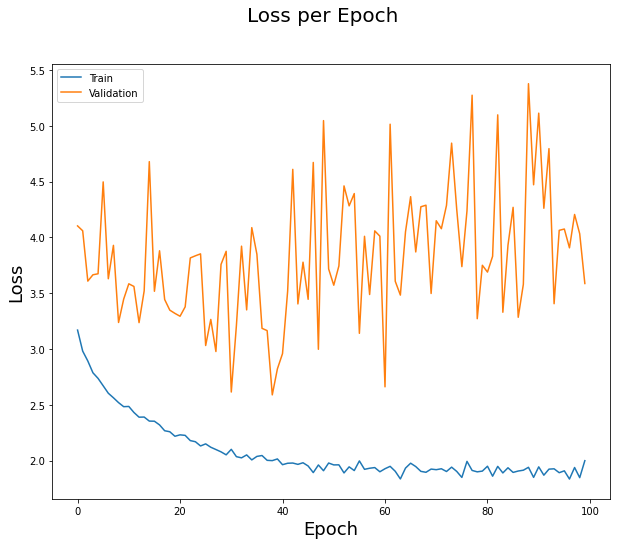

In [32]:
fig = plt.figure(figsize=(10,8))
fig.suptitle('Loss per Epoch', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.plot(train_losses, label='Train')
plt.plot(valid_losses, label='Validation')
plt.legend()

In [33]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [34]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.25      1.00      0.40         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           8       0.25      1.00      0.40         1
           9       0.00      0.00      0.00         1
          10       1.00      1.00      1.00         1
          11       0.25      1.00      0.40         1
          12       1.00      1.00      1.00         1
          13       0.50      1.00      0.67         1
          14       0.50      1.00      0.67         1
          15       1.00      1.00      1.00         1
          16       0.00      0.00      0.00         1
          17       1.00      1.00      1.00         1
          18       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
text = ["Create a post for me"]

In [36]:
tokens = tokenizer.batch_encode_plus(
    text,
    max_length = max_seq_len,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)
seq = torch.tensor(tokens['input_ids'])
mask = torch.tensor(tokens['attention_mask'])

In [37]:
preds =  model(seq.to(device), mask.to(device))

In [38]:
preds

tensor([[-18.0270, -16.2133,  -4.8115, -21.9217,  -7.4955,  -2.4414,  -2.0587,
         -13.3455,  -3.5186,  -4.2336,  -4.9252, -14.7103,  -9.5600,  -8.0068,
         -15.1043, -17.2597, -13.1308, -11.9756,  -8.8245,  -9.4739,  -6.6512,
         -15.6235,  -0.7322,  -1.4909,  -5.1152,  -8.5736, -11.1156,  -6.0432,
          -8.0856,  -4.7806]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)

In [39]:
preds = preds.detach().cpu().numpy()
preds = np.argmax(preds, axis = 1)

In [40]:
preds

array([22])

In [41]:
lbl_enc.inverse_transform(preds)

array(['navigate_auth'], dtype=object)